# Rank plotting for Exp 1 (cut to stitch and receiver only)

In [1]:
from pandas.errors import EmptyDataError
import pandas as pd
import os 
import glob 

csv_files = glob.glob(os.path.join("../msc_similarity/exp1_ms_with_random_dataset/results_rank/", "*.csv")) 
  
dfs = []
for f in csv_files:       
    try:
        df = pd.read_csv(f)
        if len(df) > 0:
            df['layer'] = df['name'].index + 1 
            dfs.append(df)
    except EmptyDataError:
        continue
        
df = pd.concat(dfs, ignore_index=True)

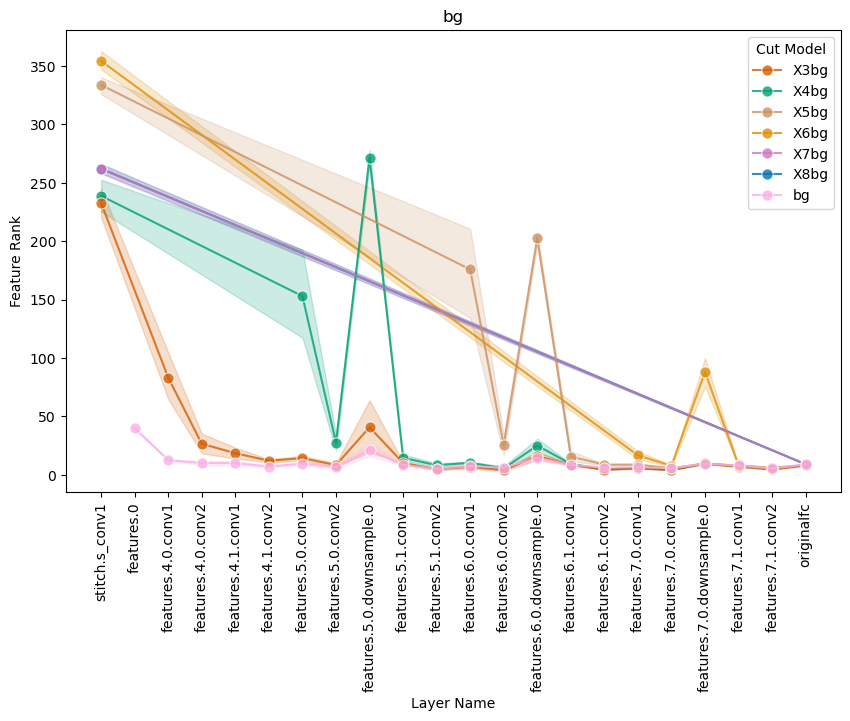

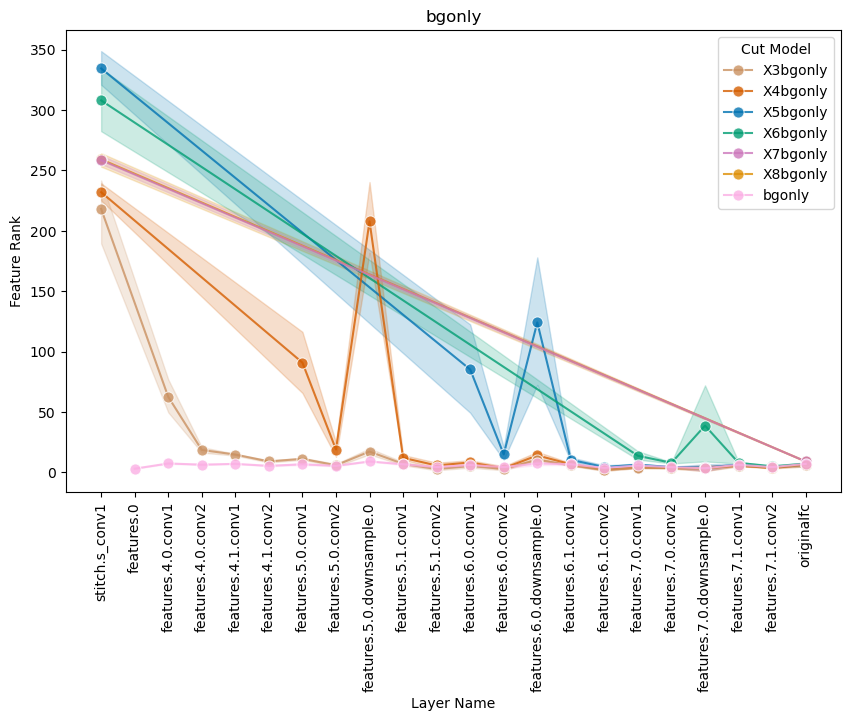

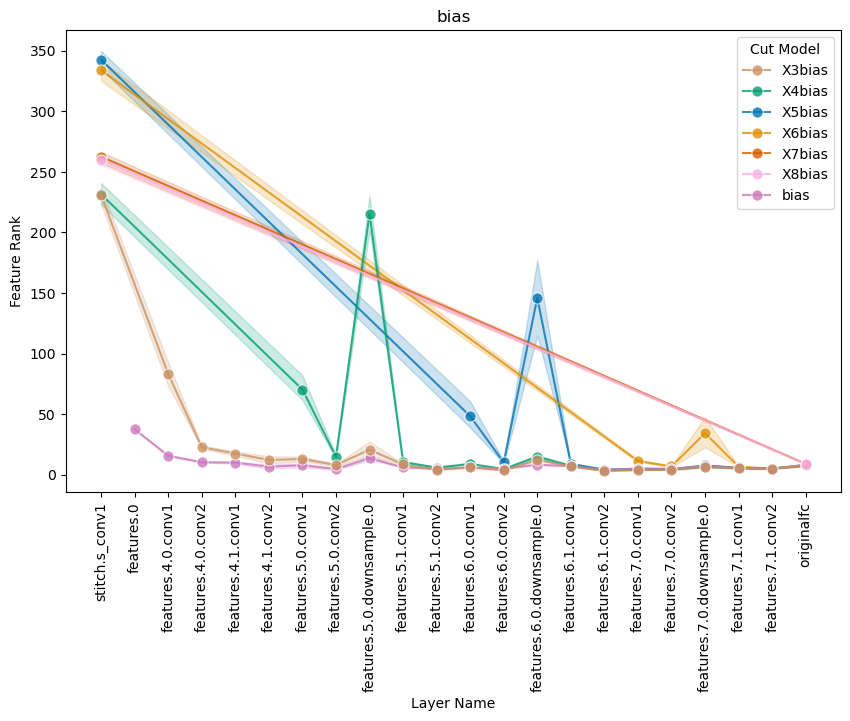

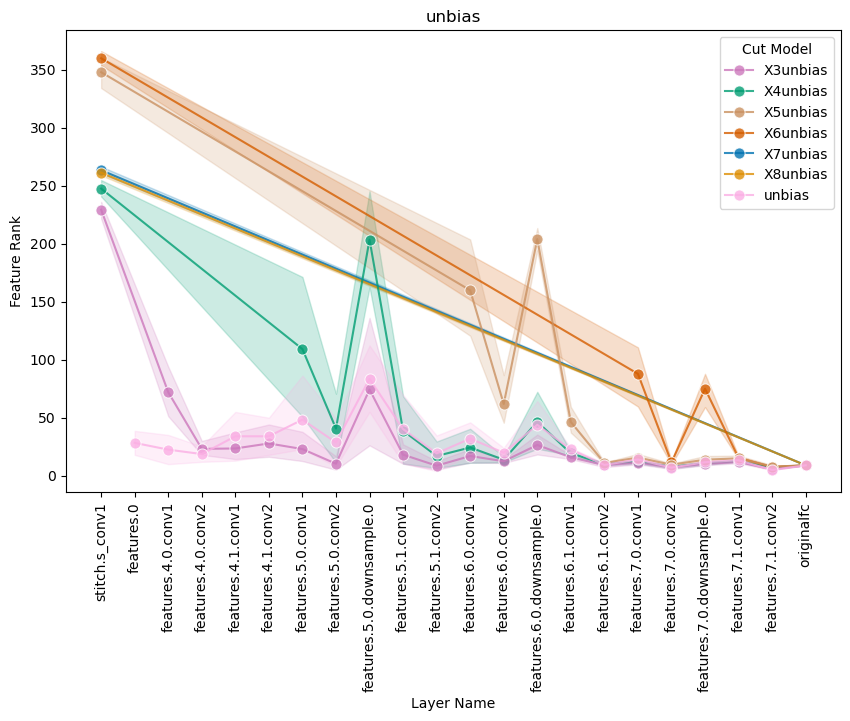

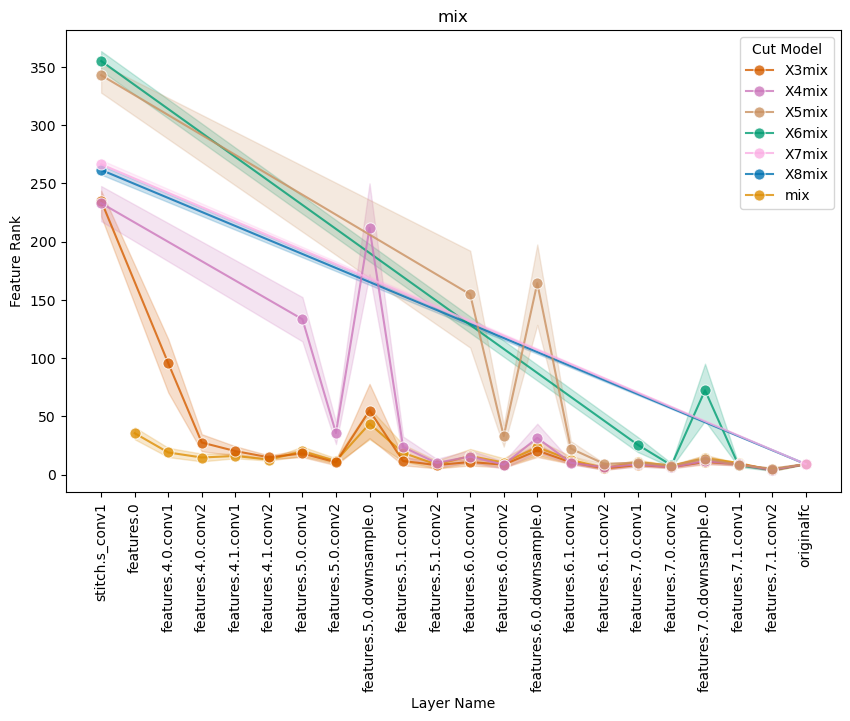

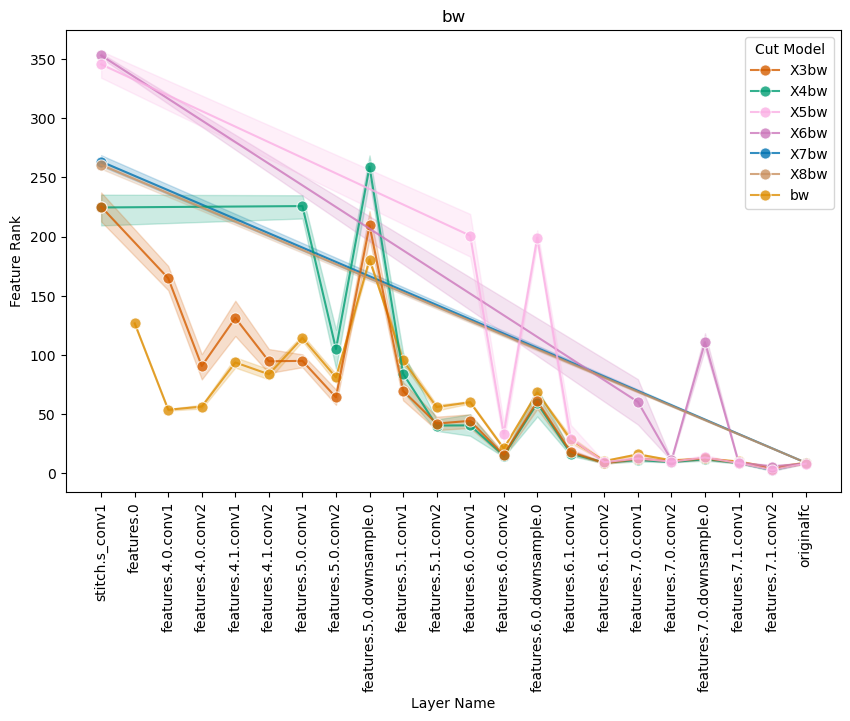

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# cheatingly noted the text names of the layers in order.
# Note that the stitch.s_conv1 layer appears first in the list, even though conceptually it 
# could be considered to be in the middle of the full network at the point of the cut
cat_order = ['stitch.s_conv1', 'features.0', 'features.4.0.conv1', 'features.4.0.conv2', 'features.4.1.conv1', 'features.4.1.conv2', 'features.5.0.conv1', 'features.5.0.conv2', 'features.5.0.downsample.0', 'features.5.1.conv1', 'features.5.1.conv2', 'features.6.0.conv1', 'features.6.0.conv2', 'features.6.0.downsample.0', 'features.6.1.conv1', 'features.6.1.conv2', 'features.7.0.conv1', 'features.7.0.conv2', 'features.7.0.downsample.0', 'features.7.1.conv1', 'features.7.1.conv2', 'originalfc']

graphs = {'bg': 'bg$', 'bgonly': 'bgonly', 'bias': '(?<!un)bias',  # these three may learn colours as a shortcut
          'unbias': 'unbias', 'mix': 'mix', 'bw': 'bw'}            # these three have to learn to read digits

for k, v in graphs.items(): 
    matchpattern = v
    # unsorted dataframe, but filtered to include only the data for one base model type
    df2 = df[(df['model'].str.contains(matchpattern)) ].copy()

    # Sort the model column and create a categorical type with sorted categories 
    # e.g models are X6bgonly or bgonly
    df2['name'] = pd.Categorical(df2['name'], categories=cat_order, ordered=True)

    # Create line plot
    plt.figure(figsize=(10, 6))
    line_plot = sns.lineplot(data=df2, x='name', y='features_rank', hue='model', marker='o', markersize=8, alpha=0.8, palette='colorblind')
    
    plt.title(k)
    plt.xlabel('Layer Name')
    plt.ylabel('Feature Rank')
    plt.xticks(rotation=90)
    
    handles, labels = line_plot.get_legend_handles_labels()
    sorted_labels_handles = sorted(zip(labels, handles))
    labels, handles = zip(*sorted_labels_handles)
    plt.legend(handles, labels, title='Cut Model', loc='upper right')
    plt.savefig(f"./results/{k}_rank.png", bbox_inches='tight')
    plt.show()


# Experiment 2 - Plot Rank After Stitch

In [3]:
from pandas.errors import EmptyDataError
import pandas as pd
import os 
import glob 

csv_files = glob.glob(os.path.join("../msc_similarity/exp2_ms_with_colorMNIST/results_rank/", "*.csv")) 

dfs_stitched = []
for f in csv_files:       
    try:
        df = pd.read_csv(f)
        if len(df) > 0:
            df['layer'] = df['name'].index + 1 
            dfs_stitched.append(df)
    except EmptyDataError:
        continue
del df
df1 = pd.concat(dfs_stitched, ignore_index=True)

csv_files += glob.glob(os.path.join("../msc_similarity/exp1_ms_with_random_dataset/results_rank/", "*.csv")) 

dfs_synth = []
for f in csv_files:       
    try:
        df = pd.read_csv(f)
        if len(df) > 0:
            df['layer'] = df['name'].index + 1 
            dfs_synth.append(df)
    except EmptyDataError:
        continue
del df


df2 = pd.concat(dfs_synth, ignore_index=True)

df3 = df2[df2['model'].str.contains('^X\dunbias')].copy()

df = pd.concat([df1, df3], ignore_index=True)
del df1, df2, df3

# Edit names to match the whole-network naming
df['name'] = df['name'].str.replace(r'_rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^send_', '', regex=True)




In [4]:
#combined_condition = pd.Series([False] * len(df))

model_match = (df['model'].str.contains(f"^unbias$"))
layer_match = (df['name'].str.contains("originalfc"))
combined_condition = (model_match & layer_match)
df[combined_condition]
#df[df['model']=='bw7unbias']

,Unnamed: 0,name,model,dataset,seed,val_acc,features_rank,features_dim,normalized_features_rank,layer
42,20,originalfc,unbias,unbias,50,0.9797,9,10,0.9,21
567,20,originalfc,unbias,bias,52,0.9804,9,10,0.9,21
2754,20,originalfc,unbias,bias,51,0.9803,9,10,0.9,21
4482,20,originalfc,unbias,bias,54,0.9807,9,10,0.9,21
4568,20,originalfc,unbias,bias,53,0.9801,9,10,0.9,21


In [5]:
send_models = {'unbias_ref': '^unbias$',
               'bg':         '^bg\d', # these three may learn colours as a shortcut
               'bgonly':     '^bgonly\d', 
               'bias':       '^bias\d',  
               'unbias':     '^unbias\d', # these three have to learn to read digits
               'mix':        '^mix\d', 
               'bw':         '^bw\d',
               'synth':      '^X\dunbias'} # syntetic random data stitched in

df['sender'] = 'unknown'
for k, v in send_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'sender'] = k


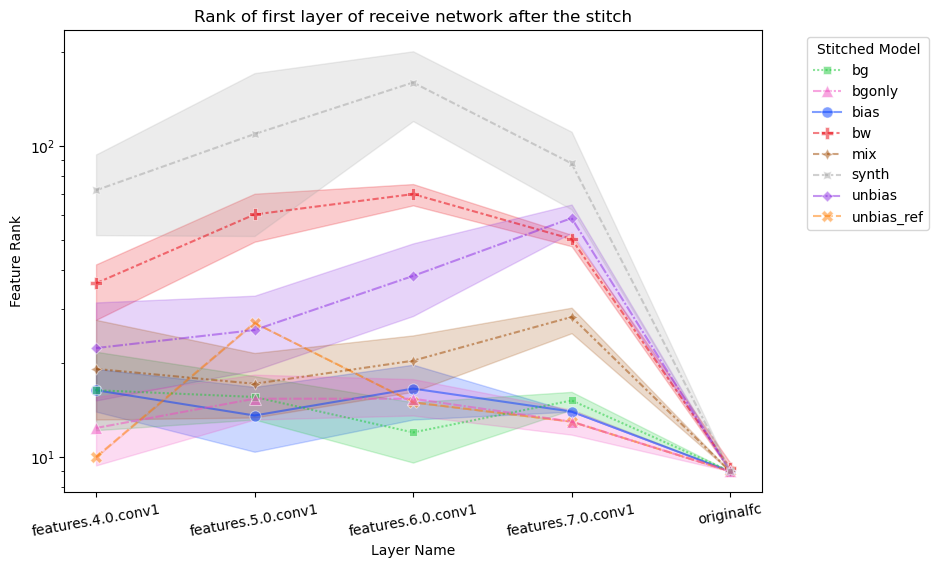

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# cheatingly noted the text names of the layers in order.
# Note that the stitch.s_conv1 layer appears first in the list, even though conceptually it 
# could be considered to be in the middle of the full network at the point of the cut
# This made sense for the truncated networks in part 1 but not 
layer_after_stitch = {3: 'features.4.0.conv1',
                      4: 'features.5.0.conv1',
                      5: 'features.6.0.conv1',
                      6: 'features.7.0.conv1',
                      7: 'originalfc'}

cat_order = ['features.4.0.conv1',  
             'features.5.0.conv1',  
             'features.6.0.conv1', 
             'features.7.0.conv1',  
             'originalfc']

combined_condition = pd.Series([False] * len(df))

for k, v in layer_after_stitch.items(): 

    model_match = (df['model'].str.contains(f"{k}"))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)

    # Add in the reference model that has no stitch, was trained on unbias dataset but has bias data input to it
    model_match = (df['model'].str.contains(send_models['unbias_ref']))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)

df2 = df[combined_condition ].copy() 
df3 = df2[df2['sender'] != 'unknown'].copy()


# Sort the model column and create a categorical type with sorted categories 
# e.g models are X6bgonly or bgonly
df3['name'] = pd.Categorical(df3['name'], categories=cat_order, ordered=True)
# Create line plot
plt.figure(figsize=(9,6))
#line_plot = sns.lineplot(data=df3, x='name', y='features_rank', hue='sender', marker='o', markersize=8, alpha=0.5, palette='bright')
line_plot = sns.lineplot(data=df3, x='name', y='features_rank', hue='sender', style='sender', markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright')

plt.title("Rank of first layer of receive network after the stitch")
plt.xlabel('Layer Name')
plt.ylabel('Feature Rank')
plt.yscale('log')
plt.xticks(rotation=10)

handles, labels = line_plot.get_legend_handles_labels()
sorted_labels_handles = sorted(zip(labels, handles))
labels, handles = zip(*sorted_labels_handles)
plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.savefig(f"./results_2/log_post_stitch_ranks.png", bbox_inches='tight')
plt.show()



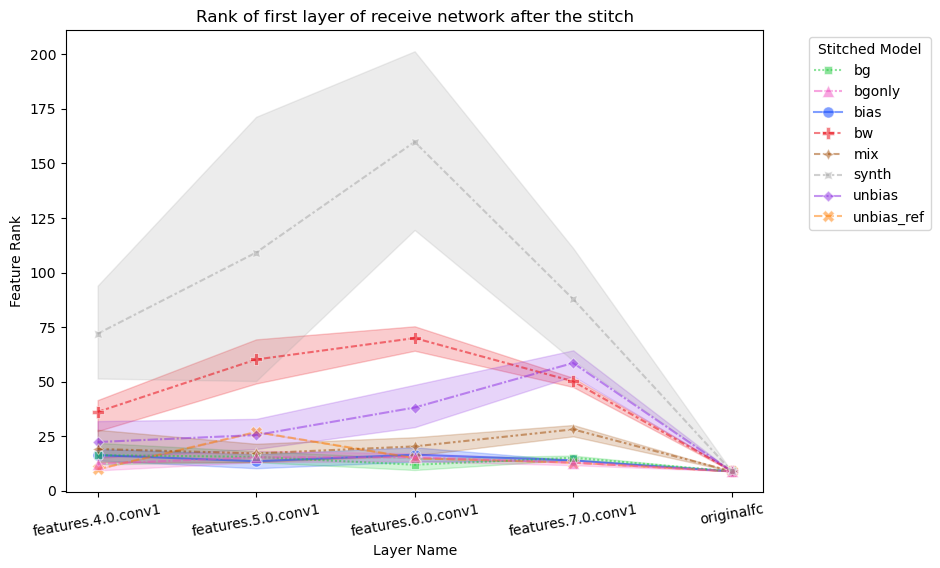

In [7]:
plt.figure(figsize=(9,6))
#line_plot = sns.lineplot(data=df3, x='name', y='features_rank', hue='sender', marker='o', markersize=8, alpha=0.5, palette='bright')
line_plot = sns.lineplot(data=df3, x='name', y='features_rank', hue='sender', style='sender', markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright')

plt.title("Rank of first layer of receive network after the stitch")
plt.xlabel('Layer Name')
plt.ylabel('Feature Rank')
#plt.ylim(6,15)
plt.yscale('linear')
plt.xticks(rotation=10)

handles, labels = line_plot.get_legend_handles_labels()
sorted_labels_handles = sorted(zip(labels, handles))
labels, handles = zip(*sorted_labels_handles)
plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.savefig(f"./results_2/log_post_stitch_ranks.png", bbox_inches='tight')
plt.show()


In [8]:
df2[df2['model']=='unbias']

,Unnamed: 0,name,model,dataset,seed,val_acc,features_rank,features_dim,normalized_features_rank,layer,sender
23,1,features.4.0.conv1,unbias,unbias,50,0.9797,10,3136,0.003189,2,unbias_ref
27,5,features.5.0.conv1,unbias,unbias,50,0.9797,27,2048,0.013184,6,unbias_ref
32,10,features.6.0.conv1,unbias,unbias,50,0.9797,15,1024,0.014648,11,unbias_ref
37,15,features.7.0.conv1,unbias,unbias,50,0.9797,13,512,0.025391,16,unbias_ref
42,20,originalfc,unbias,unbias,50,0.9797,9,10,0.900000,21,unbias_ref
548,1,features.4.0.conv1,unbias,bias,52,0.9804,10,3136,0.003189,2,unbias_ref
552,5,features.5.0.conv1,unbias,bias,52,0.9804,27,2048,0.013184,6,unbias_ref
557,10,features.6.0.conv1,unbias,bias,52,0.9804,15,1024,0.014648,11,unbias_ref
562,15,features.7.0.conv1,unbias,bias,52,0.9804,13,512,0.025391,16,unbias_ref
567,20,originalfc,unbias,bias,52,0.9804,9,10,0.900000,21,unbias_ref


# Experiment 3 plot the rank of the stitch rather than the layer after it

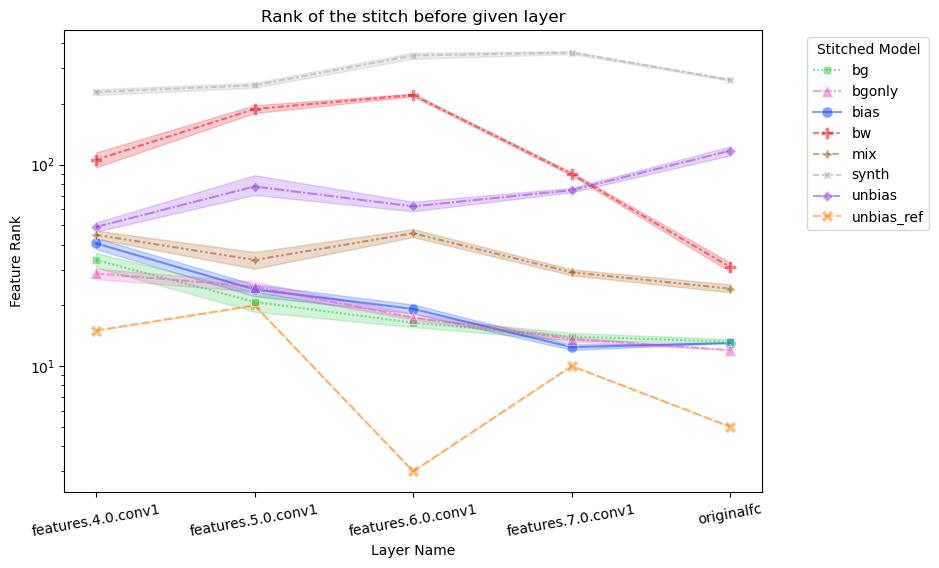

In [9]:
from pandas.errors import EmptyDataError
import pandas as pd
import os 
import glob 

csv_files = glob.glob(os.path.join("../msc_similarity/exp2_ms_with_colorMNIST/results_rank/", "*.csv")) 

dfs_stitched = []
for f in csv_files:       
    try:
        df = pd.read_csv(f)
        if len(df) > 0:
            df['layer'] = df['name'].index + 1 
            dfs_stitched.append(df)
    except EmptyDataError:
        continue
del df
df1 = pd.concat(dfs_stitched, ignore_index=True)

csv_files += glob.glob(os.path.join("../msc_similarity/exp1_ms_with_random_dataset/results_rank/", "*.csv")) 

dfs_synth = []
for f in csv_files:       
    try:
        df = pd.read_csv(f)
        if len(df) > 0:
            df['layer'] = df['name'].index + 1 
            dfs_synth.append(df)
    except EmptyDataError:
        continue
del df


df2 = pd.concat(dfs_synth, ignore_index=True)

df3 = df2[df2['model'].str.contains('^X\dunbias')].copy()

df = pd.concat([df1, df3], ignore_index=True)
del df1, df2, df3

# Edit names to match the whole-network naming
df['name'] = df['name'].str.replace(r'_rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^send_', '', regex=True)

send_models = {'unbias_ref': '^unbias$',
               'bg':         '^bg\d', # these three may learn colours as a shortcut
               'bgonly':     '^bgonly\d', 
               'bias':       '^bias\d',  
               'unbias':     '^unbias\d', # these three have to learn to read digits
               'mix':        '^mix\d', 
               'bw':         '^bw\d',
               'synth':      '^X\dunbias'} # syntetic random data stitched in

df['sender'] = 'unknown'
for k, v in send_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'sender'] = k

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# cheatingly noted the text names of the layers in order.
# Note that the stitch.s_conv1 layer appears first in the list, even though conceptually it 
# could be considered to be in the middle of the full network at the point of the cut
# This made sense for the truncated networks in part 1 but not 
#                         preceder for rcvr      stitch
layer_of_stitch =    {3: ('features.0'         ,'stitch.s_conv1'),
                      4: ('features.4.1.conv2' ,'stitch.s_conv1'),
                      5: ('features.5.1.conv2' ,'stitch.s_conv1'),
                      6: ('features.6.1.conv2' ,'stitch.s_conv1'),
                      7: ('features.7.1.conv2' ,'stitch.s_conv1')}

cat_order = ['features.4.0.conv1',  
             'features.5.0.conv1',  
             'features.6.0.conv1', 
             'features.7.0.conv1',  
             'originalfc']

combined_condition = pd.Series([False] * len(df))
df['stitch_before'] = 'unknown'
        
for k, v in layer_of_stitch.items(): 
    # The stitch layer
    model_match = (df['model'].str.contains(f"{k}"))
    layer_match = (df['name'].str.contains(v[1]))
    combined_condition_s = (model_match & layer_match)
    df.loc[combined_condition_s, 'stitch_before'] = cat_order[k-3]
    
    # Add in the reference model that has no stitch, was trained on unbias dataset but has bias data input to it
    model_match = (df['model'].str.contains(send_models['unbias_ref']))
    layer_match = (df['name'].str.contains(v[0]))
    combined_condition_u = (model_match & layer_match)
    df.loc[combined_condition_u, 'stitch_before'] = cat_order[k-3]
    

    combined_condition |= combined_condition_s | combined_condition_u
df2 = df[combined_condition ].copy() 
df3 = df2[df2['sender'] != 'unknown'].copy()


# Sort the model column and create a categorical type with sorted categories 
# e.g models are X6bgonly or bgonly
df3['stitch_before'] = pd.Categorical(df3['stitch_before'], categories=cat_order, ordered=True)
# Create line plot
plt.figure(figsize=(9,6))
#line_plot = sns.lineplot(data=df3, x='name', y='features_rank', hue='sender', marker='o', markersize=8, alpha=0.5, palette='bright')
line_plot = sns.lineplot(data=df3, x='stitch_before', y='features_rank', hue='sender', style='sender', markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright')

plt.title("Rank of the stitch before given layer")
plt.xlabel('Layer Name')
plt.ylabel('Feature Rank')
plt.yscale('log')
plt.xticks(rotation=10)

handles, labels = line_plot.get_legend_handles_labels()
sorted_labels_handles = sorted(zip(labels, handles))
labels, handles = zip(*sorted_labels_handles)
plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.savefig(f"./results_3/log_post_stitch_ranks.png", bbox_inches='tight')
plt.show()
